In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
import os
from pathlib import Path
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_excel('data_SK.xlsx', sheet_name='ผลตอบแทน (6263-6566) ภาษาอังกฤษ')
data

,factory,year,unit_zone,zone,director_zone,explorer,type,quota,quota : name,weight (tons),net return,debt,sugar cane procurement,spend
0,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10486,10486 : สลิน เปียมั่น,0.00,3.142144e+04,-31421.44,0.0,-31421.44
1,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10487,10487 : เอมอร ภาวะโพธิ์,0.00,3.208680e+04,-32086.80,0.0,-32086.80
2,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10492,10492 : สมเพชร พรสงวน,0.00,2.898131e+04,-28981.31,0.0,-28981.31
3,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10896,10896 : เรือง ผาสีดา,0.00,0.000000e+00,0.00,0.0,0.00
4,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,11203,11203 : กฤต กรเดชากุล,0.00,-2.369373e+06,2369372.62,0.0,2369372.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ไม่ส่งเสริมต่อ,10310,10310 : วีระพงษ์ นามขันธ์,91.19,1.439358e+05,-93127.79,0.0,-93127.79
4093,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ไม่ส่งเสริมต่อ,10323,10323 : แดง ไชยพิทักษ์,13.09,1.687858e+04,-9585.27,0.0,-9585.27
4094,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ยังส่งเสริมต่อ,10243,10243 : นำสมัย ฐานทองดี,53.45,2.487143e+04,4909.13,0.0,4909.13
4095,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ยังส่งเสริมต่อ,10324,10324 : ชัยรัตน์ โสมชัย,19.91,-2.167469e+04,32767.88,0.0,32767.88


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'zone'}>,
        <AxesSubplot:title={'center':'quota'}>],
       [<AxesSubplot:title={'center':'weight (tons)'}>,
        <AxesSubplot:title={'center':'net return'}>,
        <AxesSubplot:title={'center':'debt'}>],
       [<AxesSubplot:title={'center':'sugar cane procurement'}>,
        <AxesSubplot:title={'center':'spend'}>, <AxesSubplot:>]],
      dtype=object)

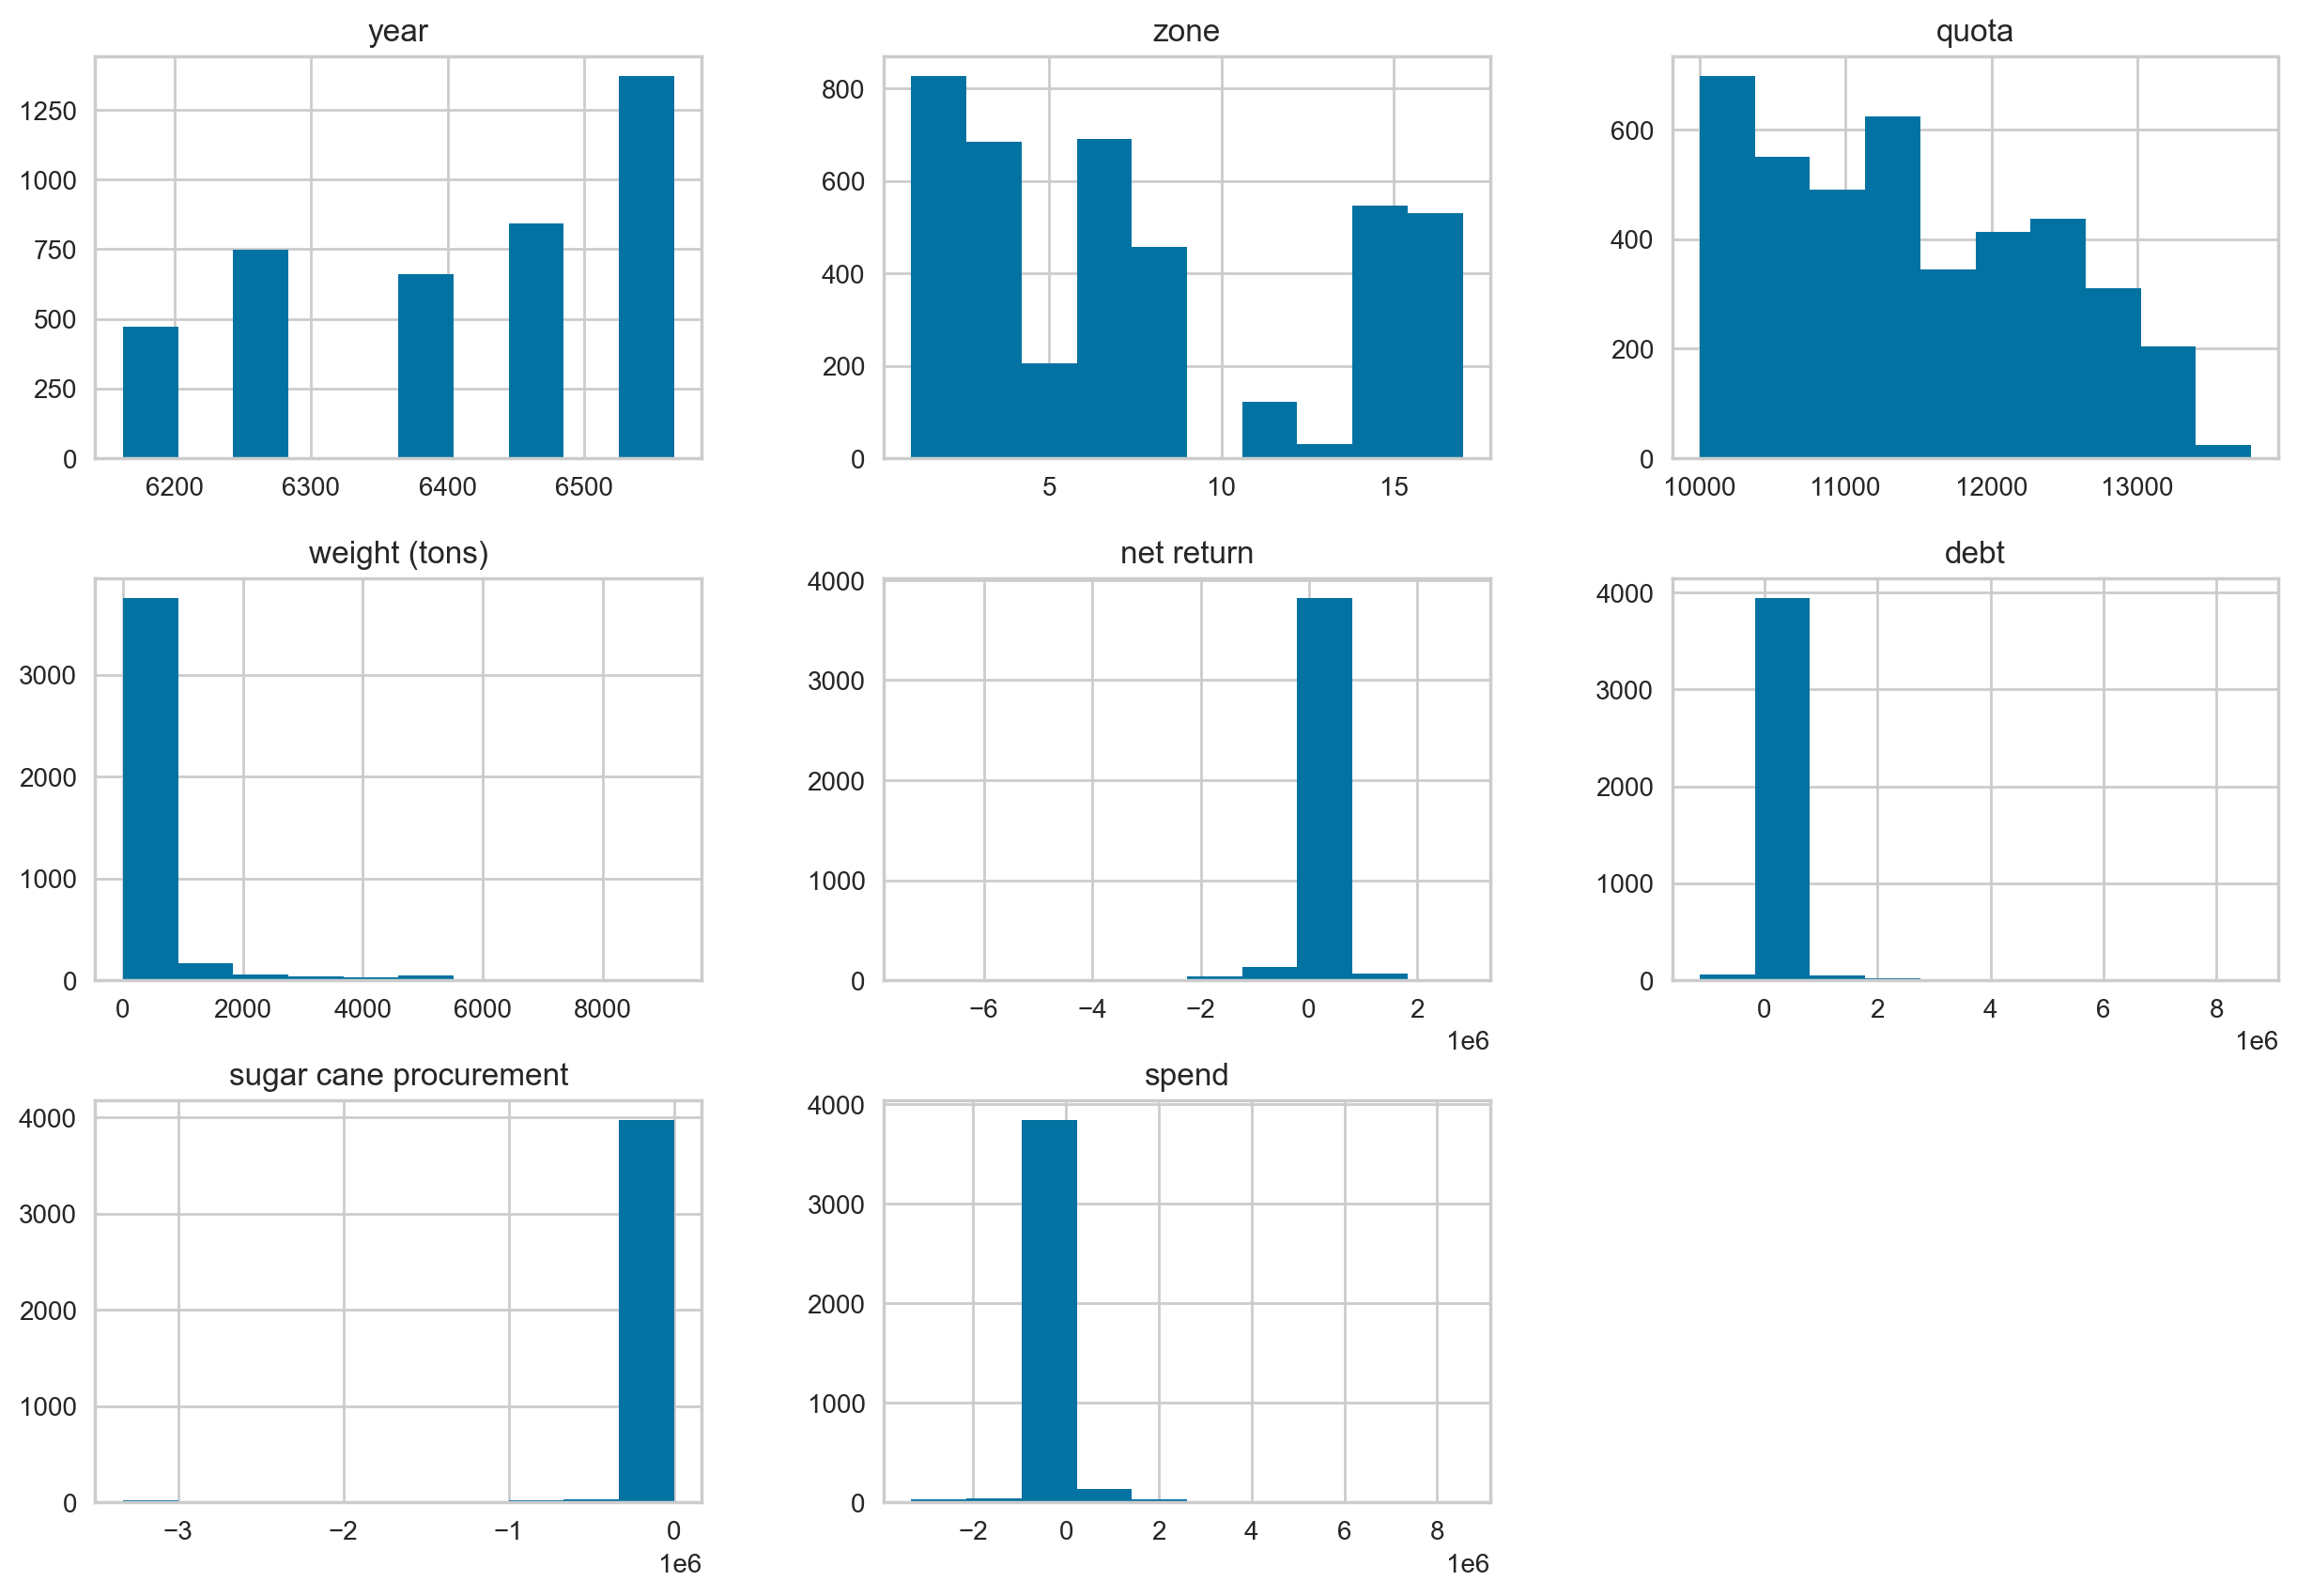

In [3]:
data.hist(figsize = (15,10))

In [4]:
#รายละเอียดข้อมูล

data.describe()

,year,zone,quota,weight (tons),net return,debt,sugar cane procurement,spend
count,4097.000000,4097.000000,4097.000000,4097.000000,4.097000e+03,4.097000e+03,4.097000e+03,4.097000e+03
mean,6410.765194,7.606053,11426.660483,318.157937,3.355711e+04,5.733370e+04,-5.102699e+04,6.306702e+03
std,141.984317,5.339320,943.403432,768.723104,4.085139e+05,3.835411e+05,3.004250e+05,4.859832e+05
min,6162.000000,1.000000,10001.000000,0.000000,-7.342775e+06,-1.143915e+06,-3.334832e+06,-3.334832e+06
25%,6263.000000,3.000000,10610.000000,9.040000,3.519225e+02,0.000000e+00,0.000000e+00,-9.000000e+03
50%,6465.000000,6.000000,11314.000000,74.060000,2.738092e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,6566.000000,14.000000,12204.000000,236.670000,8.226807e+04,6.516000e+03,0.000000e+00,0.000000e+00
max,6566.000000,17.000000,13779.000000,9193.250000,2.834873e+06,8.610000e+06,0.000000e+00,8.548544e+06


## แปลงข้อมูลให้อยู่ในมาตรฐานเดียวกันด้วยวิธีของ yeo-johnson

In [5]:
from sklearn import preprocessing

In [6]:
data.columns

Index(['factory', 'year', 'unit_zone', 'zone', 'director_zone', 'explorer',
       'type', 'quota', 'quota : name', 'weight (tons)', 'net return', 'debt',
       'sugar cane procurement', 'spend'],
      dtype='object')

In [7]:
#แปลงข้อมูลด้วย yeo-johnson (แปลงให้ข้อมูลอยู่ในมาตรฐานเดียวกัน)

cols = ['weight (tons)', 'net return', 'spend']
pt = preprocessing.PowerTransformer(method = 'yeo-johnson', standardize = True)
mat = pt.fit_transform(data[cols])
mat[:5].round(4)

array([[-1.4667, -0.1444, -0.0515],
       [-1.4667, -0.1421, -0.053 ],
       [-1.4667, -0.1529, -0.0459],
       [-1.4667, -0.2495,  0.0202],
       [-1.4667, -3.8011,  4.3176]])

In [8]:
yj_cols = [f'yj_{c}' for c in cols]
yj_cols

['yj_weight (tons)', 'yj_net return', 'yj_spend']

In [9]:
#แสดงในรูปแบบตาราง

trans_data = pd.concat([data, pd.DataFrame(mat, columns = yj_cols)], axis = 'columns')  #, pd.DataFrame(z, columns = z_cols)], axis = 'columns')
trans_data

,factory,year,unit_zone,zone,director_zone,explorer,type,quota,quota : name,weight (tons),net return,debt,sugar cane procurement,spend,yj_weight (tons),yj_net return,yj_spend
0,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10486,10486 : สลิน เปียมั่น,0.00,3.142144e+04,-31421.44,0.0,-31421.44,-1.466658,-0.144418,-0.051505
1,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10487,10487 : เอมอร ภาวะโพธิ์,0.00,3.208680e+04,-32086.80,0.0,-32086.80,-1.466658,-0.142114,-0.053040
2,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10492,10492 : สมเพชร พรสงวน,0.00,2.898131e+04,-28981.31,0.0,-28981.31,-1.466658,-0.152853,-0.045880
3,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10896,10896 : เรือง ผาสีดา,0.00,0.000000e+00,0.00,0.0,0.00,-1.466658,-0.249524,0.020245
4,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,11203,11203 : กฤต กรเดชากุล,0.00,-2.369373e+06,2369372.62,0.0,2369372.62,-1.466658,-3.801051,4.317562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ไม่ส่งเสริมต่อ,10310,10310 : วีระพงษ์ นามขันธ์,91.19,1.439358e+05,-93127.79,0.0,-93127.79,0.215838,0.258168,-0.194732
4093,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ไม่ส่งเสริมต่อ,10323,10323 : แดง ไชยพิทักษ์,13.09,1.687858e+04,-9585.27,0.0,-9585.27,-0.558862,-0.194274,-0.001385
4094,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ยังส่งเสริมต่อ,10243,10243 : นำสมัย ฐานทองดี,53.45,2.487143e+04,4909.13,0.0,4909.13,-0.013460,-0.167003,0.029716
4095,SK,6566,ล่าง,17,กมลชาติ ชัยพุทธา,ภูเบศ ขันคำ,หนี้มีปัญหา ยังส่งเสริมต่อ,10324,10324 : ชัยรัตน์ โสมชัย,19.91,-2.167469e+04,32767.88,0.0,32767.88,-0.405772,-0.287787,0.082275


In [10]:
#filter เอาแค่เขตบน

data_filtered = trans_data.loc[(trans_data.unit_zone == 'บน')]
data_filtered

,factory,year,unit_zone,zone,director_zone,explorer,type,quota,quota : name,weight (tons),net return,debt,sugar cane procurement,spend,yj_weight (tons),yj_net return,yj_spend
0,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10486,10486 : สลิน เปียมั่น,0.000,3.142144e+04,-31421.44,0.00,-31421.44,-1.466658,-0.144418,-0.051505
1,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10487,10487 : เอมอร ภาวะโพธิ์,0.000,3.208680e+04,-32086.80,0.00,-32086.80,-1.466658,-0.142114,-0.053040
2,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10492,10492 : สมเพชร พรสงวน,0.000,2.898131e+04,-28981.31,0.00,-28981.31,-1.466658,-0.152853,-0.045880
3,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10896,10896 : เรือง ผาสีดา,0.000,0.000000e+00,0.00,0.00,0.00,-1.466658,-0.249524,0.020245
4,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,11203,11203 : กฤต กรเดชากุล,0.000,-2.369373e+06,2369372.62,0.00,2369372.62,-1.466658,-3.801051,4.317562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3585,SK,6566,บน,15,วีระพงษ์ กาลสุข,อาทิตย์ แก้วบับภา,หนี้ปกติ,12519,12519 : เจนจิรา หงษ์ชูตา,340.155,1.323431e+05,0.00,-57180.00,-57180.00,0.830242,0.215914,-0.111108
3586,SK,6566,บน,15,วีระพงษ์ กาลสุข,อาทิตย์ แก้วบับภา,หนี้ปกติ,12521,12521 : ไชยสิทธิ์ วงค์ประทุม,80.137,1.551457e+04,7020.00,-22115.10,-15095.10,0.159315,-0.198887,-0.013973
3587,SK,6566,บน,15,วีระพงษ์ กาลสุข,อาทิตย์ แก้วบับภา,หนี้ปกติ,12584,12584 : สุมินครา พรมสอน,208.904,6.976960e+04,13004.00,-33620.77,-20616.77,0.594485,-0.009565,-0.026635
3588,SK,6566,บน,15,วีระพงษ์ กาลสุข,อาทิตย์ แก้วบับภา,หนี้ปกติ,12835,12835 : อุทัย แพทย์ชา,123.236,4.509917e+04,0.00,-23563.83,-23563.83,0.350195,-0.096754,-0.033408


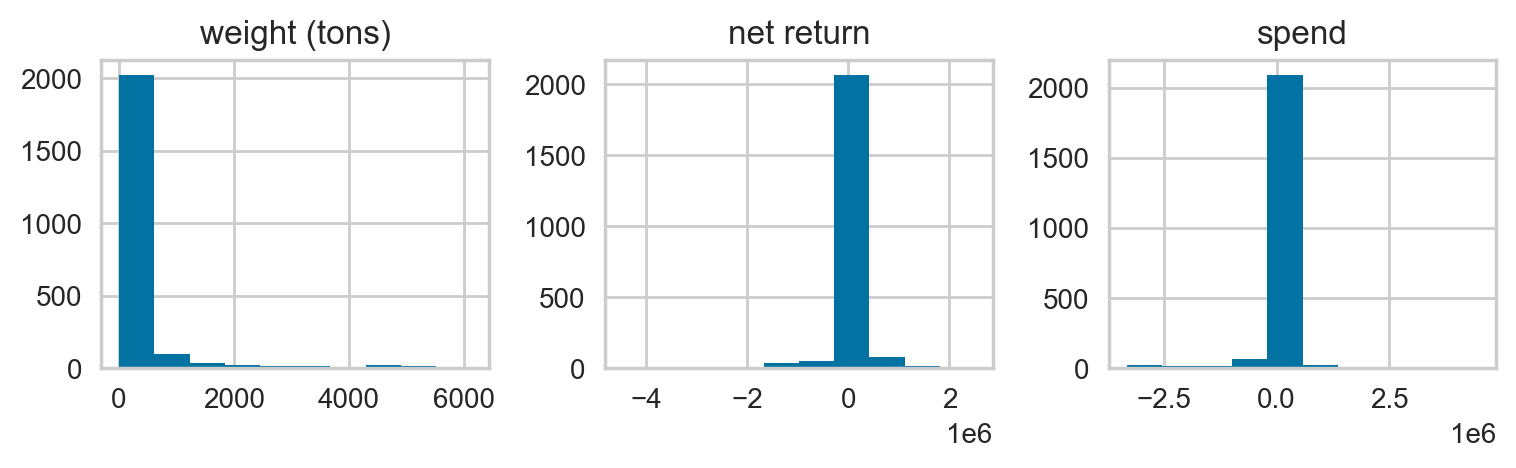

In [11]:
#plot กราฟดูข้อมูล (ยังไม่แปลงข้อมูล)

data_filtered[cols].hist(layout = (1, len(cols)), figsize = (3*len(cols), 2));

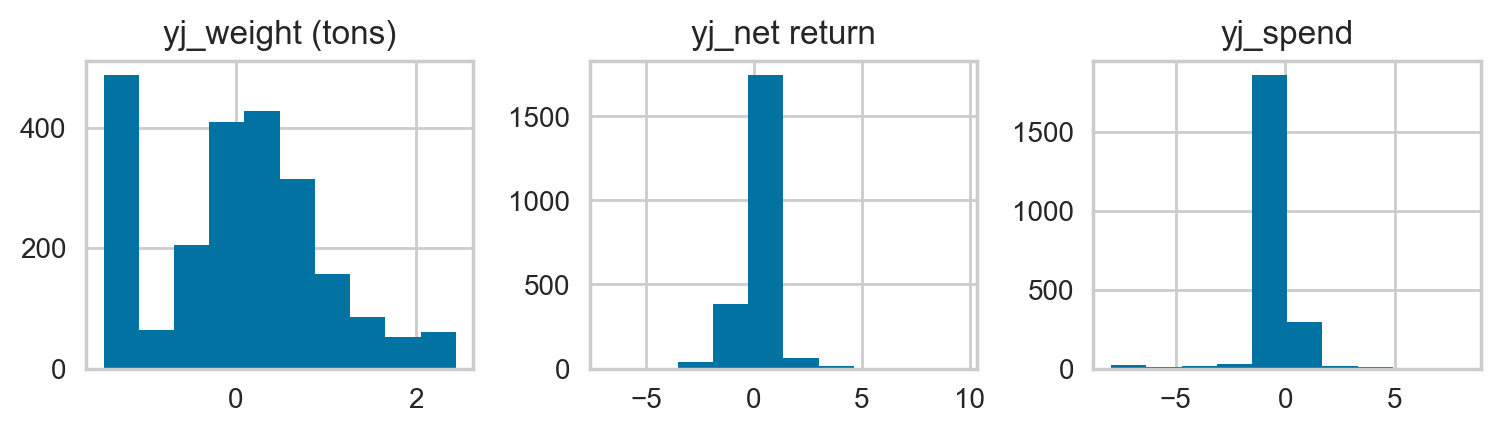

In [12]:
#plot กราฟดูข้อมูล (แปลงข้อมูลแล้ว)

data_filtered[yj_cols].hist(layout = (1, len(cols)), figsize = (3*len(cols), 2));

In [13]:
#แสดงตัวอย่างนิดหน่อยของข้อมูลที่ถูกแปลงให้อยู่ในมาตรฐานเดียวกันแล้ว

X = pd.DataFrame(mat, columns = cols)
X.head()

,weight (tons),net return,spend
0,-1.466658,-0.144418,-0.051505
1,-1.466658,-0.142114,-0.053040
2,-1.466658,-0.152853,-0.045880
3,-1.466658,-0.249524,0.020245
4,-1.466658,-3.801051,4.317562


In [14]:
#มีข้อมูลที่เป็น null มั้ย

data_filtered[yj_cols].isnull().sum()

yj_weight (tons)    0
yj_net return       0
yj_spend            0
dtype: int64

## หาจำนวนกลุ่มที่เหมาะสมด้วยวิธี Elbow 

In [15]:
ssd = []
for k in range(1, 10):
    m = KMeans(n_clusters = k)
    m.fit(X)
    ssd.append([k, m.inertia_])
ssd

[[1, 12290.99999999999],
 [2, 9269.746006742822],
 [3, 7182.856653649187],
 [4, 5191.060486291337],
 [5, 3253.126037803628],
 [6, 2495.754566675152],
 [7, 1956.7390581843738],
 [8, 1612.9079245521425],
 [9, 1394.4155897445478]]

In [16]:
xy = np.array(ssd)
print(xy)

[[1.00000000e+00 1.22910000e+04]
 [2.00000000e+00 9.26974601e+03]
 [3.00000000e+00 7.18285665e+03]
 [4.00000000e+00 5.19106049e+03]
 [5.00000000e+00 3.25312604e+03]
 [6.00000000e+00 2.49575457e+03]
 [7.00000000e+00 1.95673906e+03]
 [8.00000000e+00 1.61290792e+03]
 [9.00000000e+00 1.39441559e+03]]


In [17]:
data_filtered.columns

Index(['factory', 'year', 'unit_zone', 'zone', 'director_zone', 'explorer',
       'type', 'quota', 'quota : name', 'weight (tons)', 'net return', 'debt',
       'sugar cane procurement', 'spend', 'yj_weight (tons)', 'yj_net return',
       'yj_spend'],
      dtype='object')

In [18]:
#ใช้ข้อมูลที่แปลงแล้วมาหา cluster ที่เหมาะสม

new_data = data_filtered[['yj_weight (tons)', 'yj_net return', 'yj_spend']]

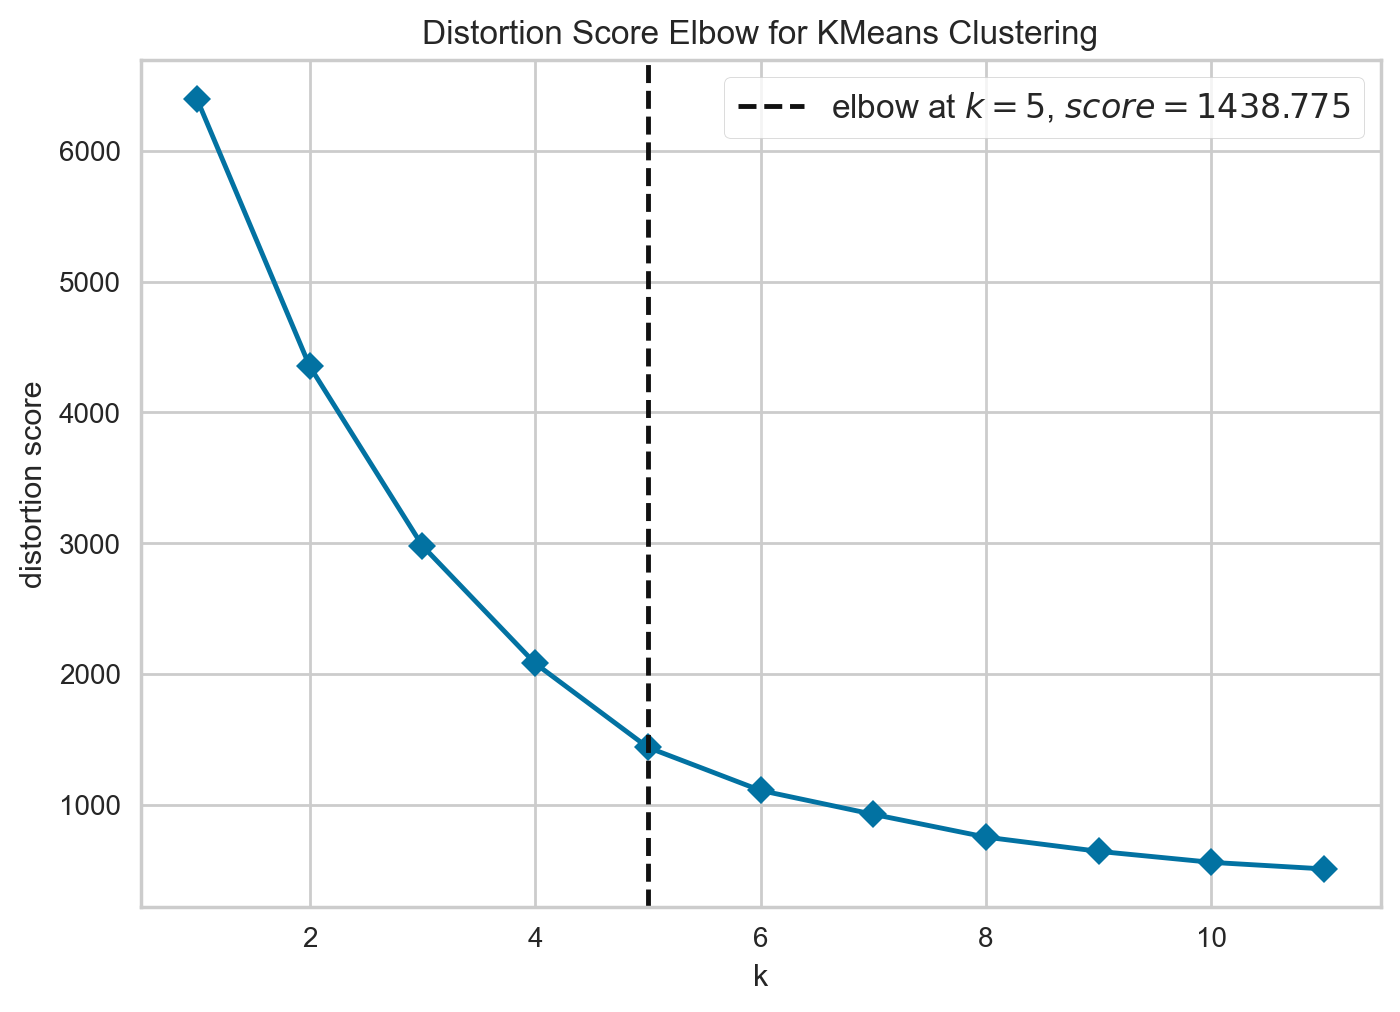

Optimal number of clusters : 5


In [19]:
visualizer = KElbowVisualizer(KMeans(init = 'k-means++', random_state = 100), k = (1,12), timings = False)
visualizer.fit(new_data)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters :", n_clusters)

## Plot กราฟ 3 มิติ ที่จัดกลุ่มแล้ว 

In [20]:
use_data = data_filtered[['weight (tons)', 'net return', 'spend']]

In [21]:
km = KMeans(5)
clusts = km.fit_predict(use_data)

In [22]:
#คำสั่งนี้สามารถหมุนกราฟได้ 360 องศา

#%matplotlib qt
#%pylab qt

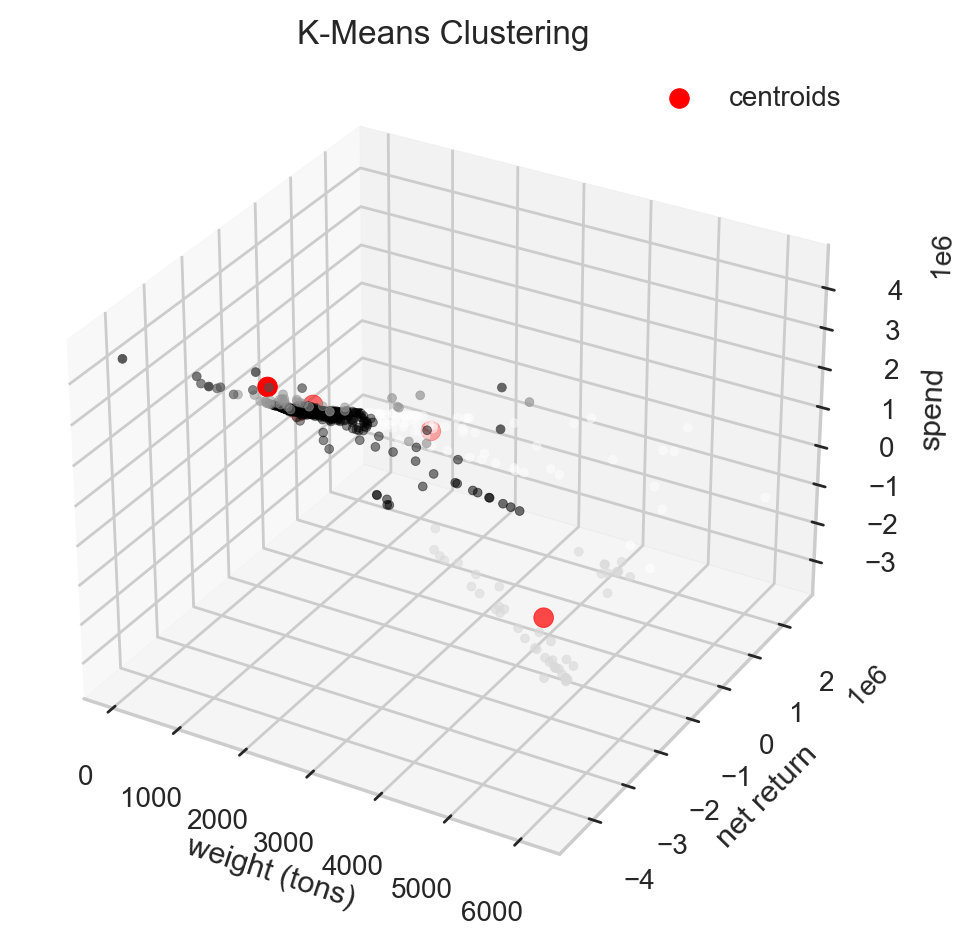

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
scatter = ax.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            km.cluster_centers_[:, 2],
            s = 50,
            marker = 'o',
            c = 'red',
            label = 'centroids')
scatter = ax.scatter(use_data['weight (tons)'], use_data['net return'], use_data['spend'], c = clusts, s = 10)


ax.set_title('K-Means Clustering')
ax.set_xlabel('weight (tons)')
ax.set_ylabel('net return')
ax.set_zlabel('spend')
ax.legend()
plt.show()

## save ข้อมูลเป็นไฟล์ xlsx โดย K = 5 

In [24]:
model = KMeans(n_clusters = 5)
model

KMeans(n_clusters=5)

In [25]:
model.fit(use_data)

KMeans(n_clusters=5)

In [26]:
data_filtered['cluster'] = model.labels_
data_filtered.head()

,factory,year,unit_zone,zone,director_zone,explorer,type,quota,quota : name,weight (tons),net return,debt,sugar cane procurement,spend,yj_weight (tons),yj_net return,yj_spend,cluster
0,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10486,10486 : สลิน เปียมั่น,0.0,31421.44,-31421.44,0.0,-31421.44,-1.466658,-0.144418,-0.051505,0
1,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10487,10487 : เอมอร ภาวะโพธิ์,0.0,32086.80,-32086.80,0.0,-32086.80,-1.466658,-0.142114,-0.053040,0
2,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10492,10492 : สมเพชร พรสงวน,0.0,28981.31,-28981.31,0.0,-28981.31,-1.466658,-0.152853,-0.045880,0
3,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,10896,10896 : เรือง ผาสีดา,0.0,0.00,0.00,0.0,0.00,-1.466658,-0.249524,0.020245,0
4,SK,6162,บน,1,อนิรุตต์ ศรีสุนทร,ไม่มีนักส่งเสริม,ปลอดภาระ,11203,11203 : กฤต กรเดชากุล,0.0,-2369372.62,2369372.62,0.0,2369372.62,-1.466658,-3.801051,4.317562,1


In [27]:
data_filtered.to_excel("เขตบน cluster = 5.xlsx")